In [12]:
# Import packages
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn import metrics
import matplotlib.pyplot as plt

In [13]:
df = pd.read_csv('ml_data/credit_card_fraud_dataset.csv')
# Shuffle the data
df = df.sample(frac = 1, random_state=42)

In [14]:
# Min-Max Scale amount column using pandas
# Initialise scaer
scaler = MinMaxScaler()
df["Amount"] = pd.DataFrame(scaler.fit_transform(df[["Amount"]]), columns=["Amount"], index=df.index)

In [15]:
# List of federal holidays 2023 & 2024
hols_2023 = ["2023-01-02", "2023-01-16", "2023-05-29", "2023-06-19", "2023-07-04", "2023-09-04", "2023-11-10", "2023-11-23", "2023-12-25"]
hols_2024 = ["2024-01-01", "2024-01-15", "2024-05-27", "2024-06-19", "2024-07-04", "2024-09-02", "2024-11-11", "2024-11-24", "2024-12-25"]

for i in range(len(hols_2023)):
    hols_2023[i] = datetime.strptime(hols_2023[i], '%Y-%m-%d')

for i in range(len(hols_2024)):
    hols_2024[i] = datetime.strptime(hols_2024[i], '%Y-%m-%d')

In [16]:
# Hot encode Location
city_encoded = pd.get_dummies(df["Location"], dtype=int)
df = pd.merge(df, city_encoded, right_index=True, left_index=True, how='inner')

# Hot encode MerchantID
# Result -> Accuracy went down
#merchant_encoded = pd.get_dummies(df['MerchantID'], drop_first=True, dtype=int,prefix='MerchID', prefix_sep='_', )
#df = pd.merge(df, merchant_encoded, right_index=True, left_index=True, how='inner')

# Hot encode Year
df["Date"] = df["TransactionDate"].astype(str).str.split(" ").str[0]
df["Year"] = df["Date"].astype(str).str.split("-").str[0]
df['Year'] = np.where(df["Year"]==2024, 1, 0)

# Hot encode month
#df["Month"] = df["Date"].astype(str).str.split("-").str[1]
#month_encoded = pd.get_dummies(df["Month"], dtype=int, drop_first=True, prefix='Month', prefix_sep='_' )
#df = pd.merge(df, month_encoded, right_index=True, left_index=True, how='inner')
df['Date'] = pd.to_datetime(df['Date']) 
df['DayOfWeek'] = df['Date'].dt.day_name()
dayofweek = pd.get_dummies(df['DayOfWeek'], dtype=int, prefix='WD', prefix_sep='_' ) 
df = pd.merge(df, dayofweek, right_index=True, left_index=True, how='inner')
# df["Day"] = df["Date"].astype(str).str.split("-").str[2]


# Change TransactionType to binary
df['TransactionType'] = np.where(df["TransactionType"]=='refund', 1, 0)

df

,TransactionID,TransactionDate,Amount,MerchantID,TransactionType,Location,IsFraud,Chicago,Dallas,Houston,...,Date,Year,DayOfWeek,WD_Friday,WD_Monday,WD_Saturday,WD_Sunday,WD_Thursday,WD_Tuesday,WD_Wednesday
75721,75722,2024-08-18 01:11:35.918051,0.806240,503,1,Phoenix,1,0,0,0,...,2024-08-18,0,Sunday,0,0,0,1,0,0,0
80184,80185,2024-06-09 07:44:35.939541,0.603707,378,0,San Diego,0,0,0,0,...,2024-06-09,0,Sunday,0,0,0,1,0,0,0
19864,19865,2024-06-10 08:55:35.558368,0.032562,406,1,San Diego,0,0,0,0,...,2024-06-10,0,Monday,0,1,0,0,0,0,0
76699,76700,2023-11-12 20:38:35.922125,0.509606,525,1,Chicago,0,1,0,0,...,2023-11-12,0,Sunday,0,0,0,1,0,0,0
92991,92992,2024-04-13 02:23:35.997572,0.658367,177,0,Chicago,0,1,0,0,...,2024-04-13,0,Saturday,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,6266,2024-09-27 16:44:35.499773,0.536845,588,1,New York,0,0,0,0,...,2024-09-27,0,Friday,1,0,0,0,0,0,0
54886,54887,2024-06-29 20:46:35.797949,0.229707,15,0,San Diego,0,0,0,0,...,2024-06-29,0,Saturday,0,0,1,0,0,0,0
76820,76821,2024-08-04 13:51:35.922781,0.699597,499,0,Philadelphia,0,0,0,0,...,2024-08-04,0,Sunday,0,0,0,1,0,0,0
860,861,2024-05-15 11:02:35.466876,0.851884,788,0,Houston,0,0,0,1,...,2024-05-15,0,Wednesday,0,0,0,0,0,0,1


In [17]:
# Naughty list
# Step 1: Filter to only fraud cases
fraud_df = df[df['IsFraud'] == 1]

# Step 2: Count fraud cases per merchant
fraud_counts = fraud_df['MerchantID'].value_counts()
#print(fraud_counts)
# Step 3: Filter to merchants with more than one fraud case
merchants_with_multiple_frauds = fraud_counts[fraud_counts > 1].index
#print(merchants_with_multiple_frauds)
fraud_list = merchants_with_multiple_frauds.to_list()

In [18]:
df['sus_merchant'] = np.where(df['MerchantID'].isin(fraud_list), 1, 0)

In [19]:
# Convert to NumPy array
public_holidays = np.array(hols_2023 + hols_2024, dtype='datetime64[D]')

In [20]:
# Check if each date is a business day
df['is_business_day'] = np.is_busday(df['Date'].values.astype('datetime64[D]'), holidays=public_holidays)

df['is_business_day'] = np.where(df['is_business_day']==True, 1, 0)

In [21]:
#

df = df.drop(columns=['TransactionID','TransactionDate', 'MerchantID', 'Location','Date', 'DayOfWeek', 'Year'])
df

# ,'WD_Friday','WD_Monday', 'WD_Saturday', 'WD_Sunday','WD_Thursday','WD_Tuesday','WD_Wednesday'

,Amount,TransactionType,IsFraud,Chicago,Dallas,Houston,Los Angeles,New York,Philadelphia,Phoenix,...,San Jose,WD_Friday,WD_Monday,WD_Saturday,WD_Sunday,WD_Thursday,WD_Tuesday,WD_Wednesday,sus_merchant,is_business_day
75721,0.806240,1,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
80184,0.603707,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
19864,0.032562,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
76699,0.509606,1,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
92991,0.658367,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,0.536845,1,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,1
54886,0.229707,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
76820,0.699597,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
860,0.851884,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [22]:
# Test train split
X_train, X_test, y_train, y_test = train_test_split(df.drop('IsFraud', axis=1),df['IsFraud'], test_size=0.25, random_state=42)

In [45]:
pen_var = None
tol_var = 1e-4
dual_var = False
c_var = 1.0
fit_intercept_var = False
intercept_scaling_var = 1
class_weight_var = 'balanced'
random_state_var = None
sol_var = 'saga'
max_iter_var = 10000
multi_class_var = 'auto'
verbose_var = 0
warm_start_var = False
n_jobs_var = None
l1_ratio_var = None


# Train the model
LogReg = LogisticRegression(penalty = pen_var, 
                            tol = tol_var,
                            dual=dual_var,
                            C = c_var,
                            fit_intercept = fit_intercept_var, 
                            intercept_scaling = intercept_scaling_var,
                            class_weight = class_weight_var,
                            random_state= random_state_var,
                            solver=sol_var,
                            max_iter=max_iter_var,
                            multi_class= multi_class_var,
                            verbose=verbose_var,
                            warm_start=warm_start_var,
                            n_jobs=n_jobs_var,
                            l1_ratio=l1_ratio_var
                             )
LogReg.fit(X_train, y_train)

/opt/miniconda3/envs/ml_environment/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/ml_environment/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(class_weight='balanced', fit_intercept=False, max_iter=10000,
                   multi_class='auto', penalty=None, solver='saga')

In [46]:
# Scoring
train_score = LogReg.score(X_train, y_train)
print(f"Training Accuracy: {round(train_score*100)}%")
test_score = LogReg.score(X_test, y_test)
print(f"Testing Accuracy: {round(test_score*100)}%")

Training Accuracy: 59%
Testing Accuracy: 59%


In [47]:
# Predictions for X_test
y_pred = LogReg.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)

[[14646 10129]
 [   95   130]]


In [48]:
# Predictions for X_test
from sklearn.metrics import f1_score
y_pred = LogReg.predict(X_test)
f1_score(y_true=y_test, y_pred=y_pred, average='weighted')

0.7348211322666222

In [49]:
# Precision
from sklearn.metrics import precision_score
precision_score(y_true=y_test, y_pred=y_pred, average='weighted')

0.9847274374250962

In [50]:
# Recall Score
from sklearn.metrics import recall_score
recall_score(y_true=y_test, y_pred=y_pred, average='weighted')

0.59104

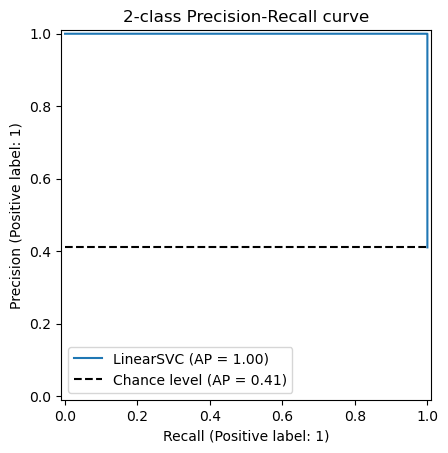

In [51]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    LogReg, X_test, y_pred, name="LinearSVC", plot_chance_level=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

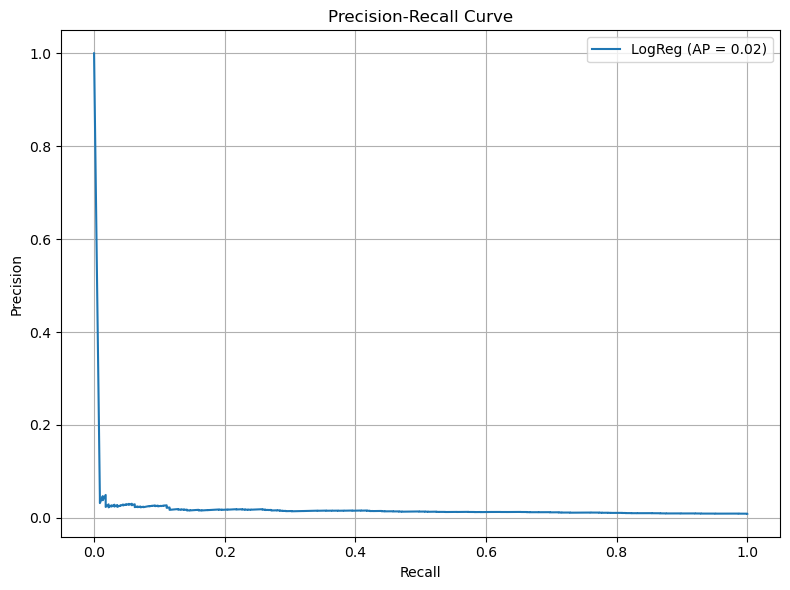

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# If y_pred is the predicted *labels*, use predict_proba instead:
# y_scores = LogReg.predict_proba(X_test)[:, 1]
# Otherwise, use y_pred directly if it's already probabilities:
y_scores =  LogReg.predict_proba(X_test)[:, 1]

# Assuming you have the true labels
# (replace y_test with your actual test labels)
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
avg_precision = average_precision_score(y_test, y_scores)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'LogReg (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

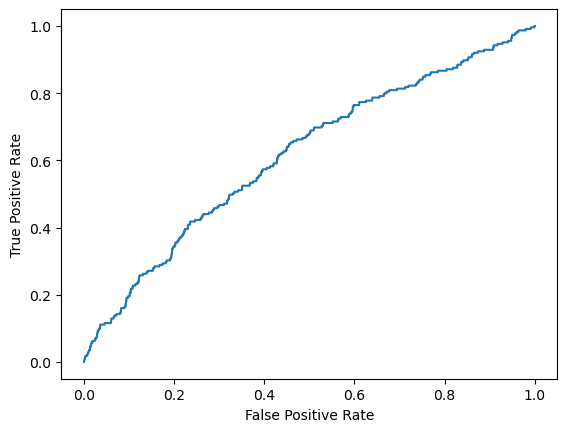

In [53]:
#define metrics
y_pred_proba = LogReg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

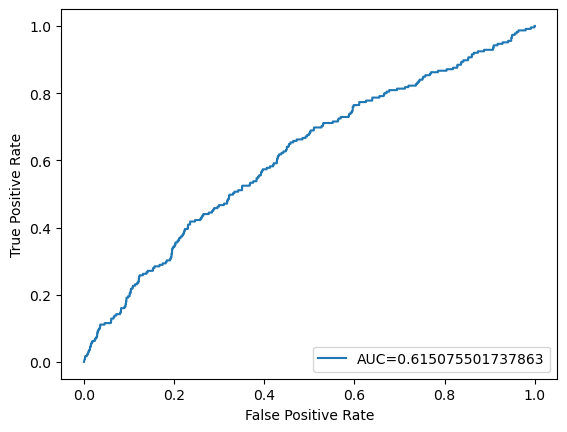

In [54]:
#define metrics
y_pred_proba = LogReg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

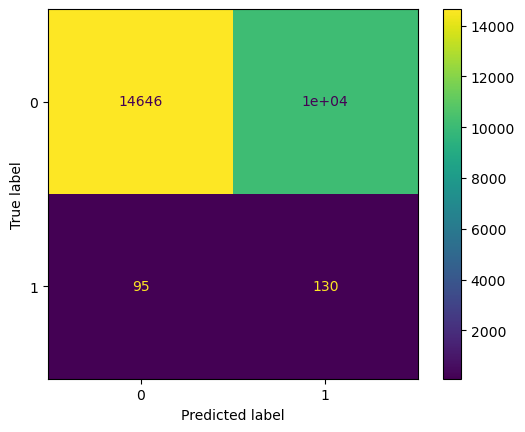

In [55]:
cm = confusion_matrix(y_test, y_pred, labels=LogReg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,

                              display_labels=LogReg.classes_)

disp.plot()

plt.show()